In [10]:
# Install required libraries
!pip install xgboost shap tensorflow scikit-learn matplotlib seaborn


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


In [17]:
import pandas as pd

df = pd.read_csv(
    "/content/data.csv",
    encoding="latin1",      # ← KEY FIX
    low_memory=False        # prevents dtype warnings
)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (435742, 13)


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [18]:
# Select relevant pollutant columns
pollutants = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
target = 'rspm'   # AQI proxy (commonly used in Indian datasets)

df = df[pollutants].copy()

# Force numeric conversion
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# TimeGAN-inspired missing value recovery
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

print("Missing values after recovery:")
print(df.isnull().sum())


Missing values after recovery:
so2      0
no2      0
rspm     0
spm      0
pm2_5    0
dtype: int64


In [19]:
X = df[pollutants].values
y = df[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)


In [20]:
# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[1])),
    Dropout(0.3),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')

lstm.fit(
    X_train_lstm, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)


Epoch 1/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1.5628e-05 - val_loss: 3.9020e-07
Epoch 2/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 1.0111e-06 - val_loss: 2.6734e-08
Epoch 3/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.5897e-07 - val_loss: 9.1362e-08
Epoch 4/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.2680e-07 - val_loss: 3.2723e-08
Epoch 5/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.2580e-07 - val_loss: 3.1550e-07
Epoch 6/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.5027e-07 - val_loss: 9.3984e-08
Epoch 7/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.3340e-07 - val_loss: 9.5743e-09
Epoch 8/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.3413e-07 - val_loss: 1.4019e-07
Epoch 9/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.1007e-07 - val_loss: 3.3837e-07
Epoch 10/25
4903/4903 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9.1358e-07 - val_loss: 2.0735e-07
Epoch 11/25
4903/4903 ━━━━━━━

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


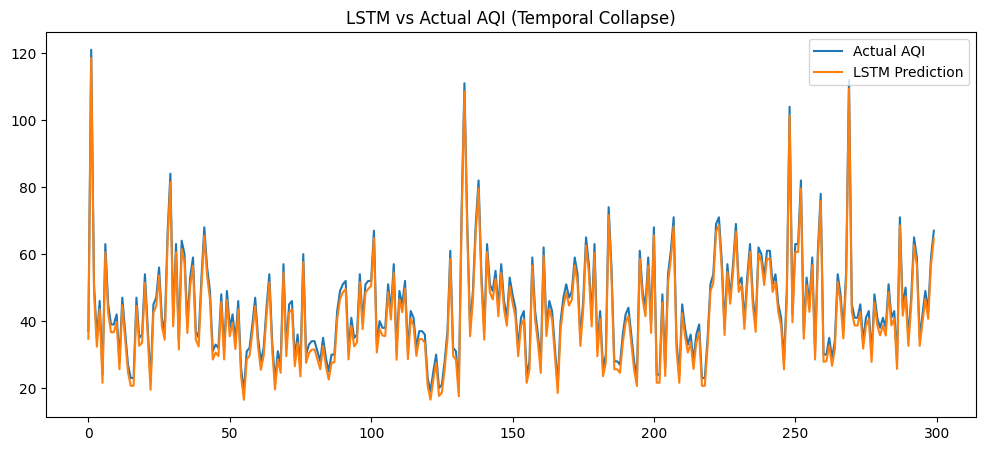

In [21]:
y_pred_lstm = scaler_y.inverse_transform(lstm.predict(X_test_lstm))
y_test_inv = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:300], label="Actual AQI")
plt.plot(y_pred_lstm[:300], label="LSTM Prediction")
plt.title("LSTM vs Actual AQI (Temporal Collapse)")
plt.legend()
plt.show()


In [22]:
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train.ravel())


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

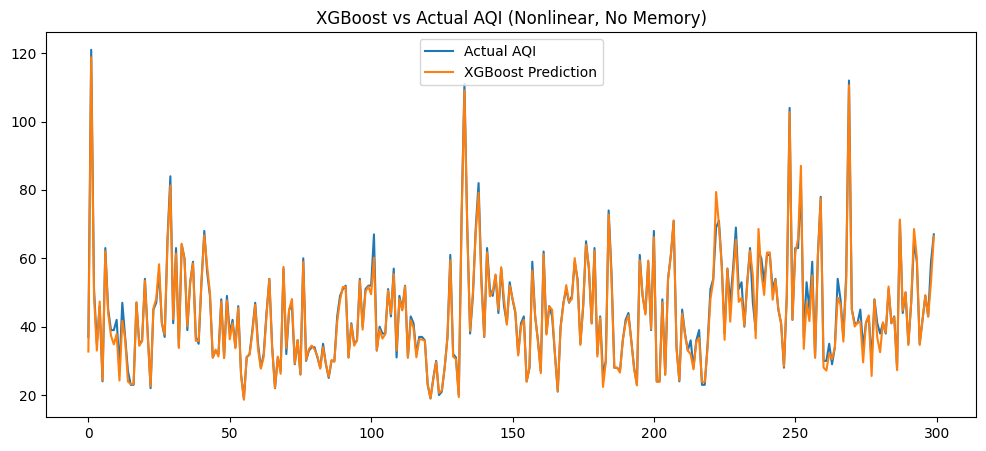

In [23]:
y_pred_xgb = scaler_y.inverse_transform(
    xgb_model.predict(X_test).reshape(-1,1)
)

plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:300], label="Actual AQI")
plt.plot(y_pred_xgb[:300], label="XGBoost Prediction")
plt.title("XGBoost vs Actual AQI (Nonlinear, No Memory)")
plt.legend()
plt.show()


In [24]:
# Convert to 1D arrays
actual = y_test_inv.flatten()
lstm_pred = y_pred_lstm.flatten()
xgb_pred = y_pred_xgb.flatten()

# Make all same length
min_len = min(len(actual), len(lstm_pred), len(xgb_pred))

actual = actual[:min_len]
lstm_pred = lstm_pred[:min_len]
xgb_pred = xgb_pred[:min_len]


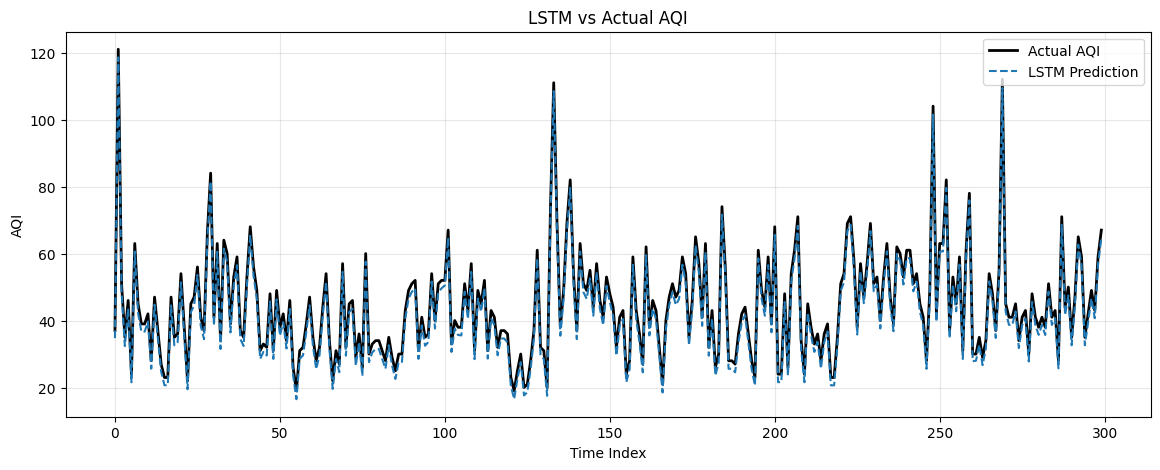

In [34]:
plt.figure(figsize=(14,5))

plt.plot(actual[:300], label="Actual AQI", color="black", linewidth=2)
plt.plot(lstm_pred[:300], label="LSTM Prediction", linestyle="--")

plt.title("LSTM vs Actual AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



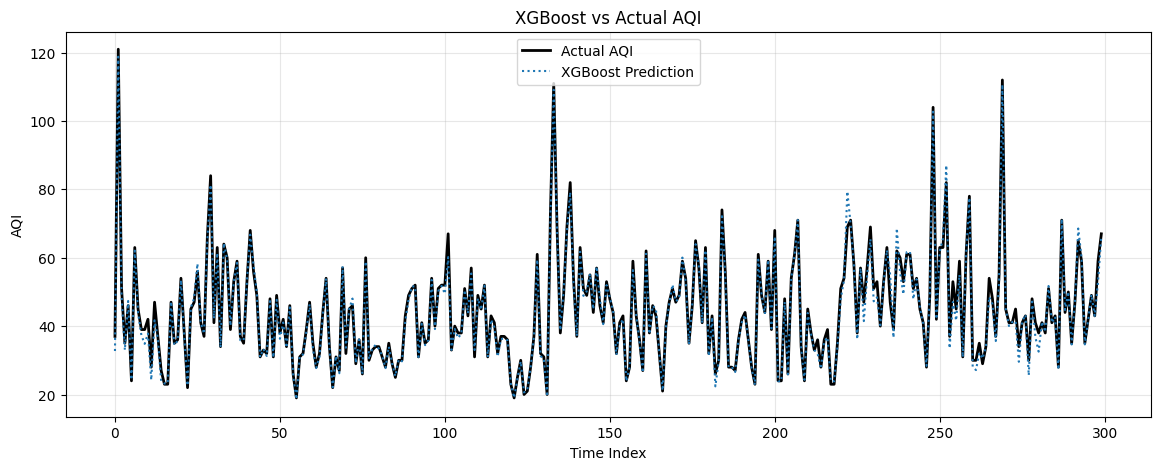

In [33]:
plt.figure(figsize=(14,5))

plt.plot(actual[:300], label="Actual AQI", color="black", linewidth=2)
plt.plot(xgb_pred[:300], label="XGBoost Prediction", linestyle=":")

plt.title("XGBoost vs Actual AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


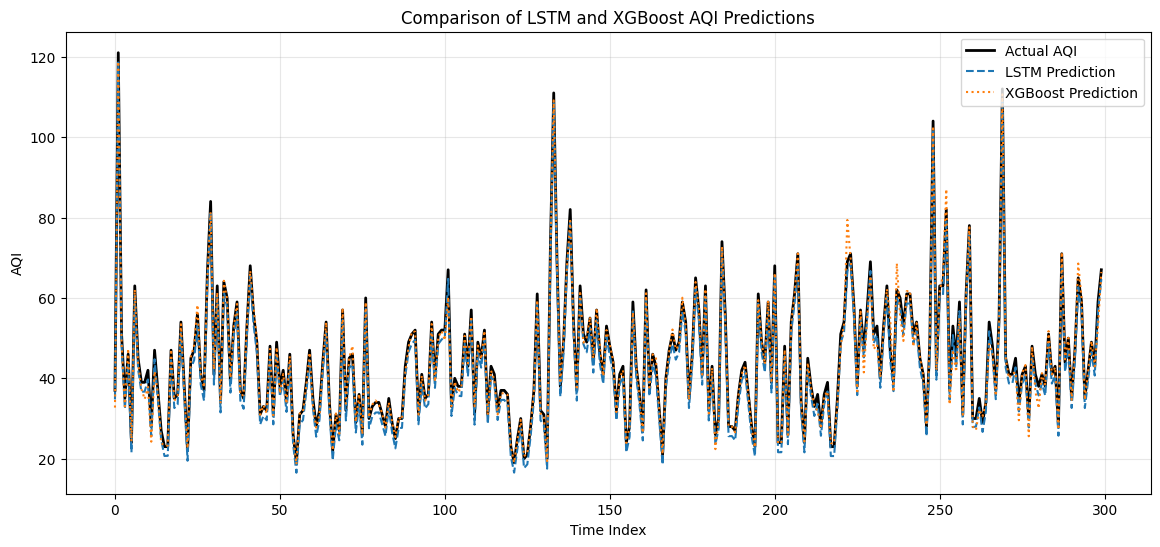

In [25]:
plt.figure(figsize=(14, 6))

plt.plot(actual[:300], label="Actual AQI", color="black", linewidth=2)
plt.plot(lstm_pred[:300], label="LSTM Prediction", linestyle="--")
plt.plot(xgb_pred[:300], label="XGBoost Prediction", linestyle=":")

plt.title("Comparison of LSTM and XGBoost AQI Predictions")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


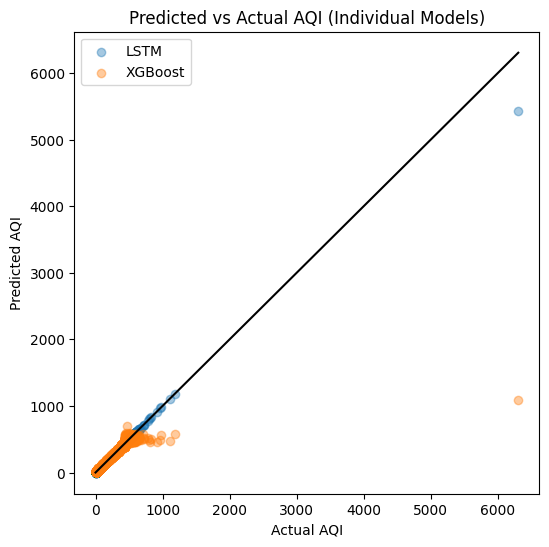

In [36]:
plt.figure(figsize=(6,6))

plt.scatter(actual, lstm_pred, alpha=0.4, label="LSTM")
plt.scatter(actual, xgb_pred, alpha=0.4, label="XGBoost")

plt.plot([actual.min(), actual.max()],
         [actual.min(), actual.max()],
         color="black")

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Predicted vs Actual AQI (Individual Models)")
plt.legend()
plt.show()
